In [120]:
import george
from george import kernels
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

import emcee
from corner import corner

In [121]:
from george.modeling import Model as mgo

class Model(mgo):
    parameter_names = ("amp", "location", "log_sigma2")
    
    def get_value(self, t): 
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))

In [127]:
def fake_data(params, N, rng=(-10, 10)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += Model(**params).get_value(t)
    yerr = 0.00005 + 0.001 * np.random.randint(N)
    yerr += 0.1 * abs(yerr * np.random.normal(0, 1, N))
    return t, y, yerr

In [135]:
true = dict(amp=-1, location=0, log_sigma2=np.log(0.4))

In [136]:
t, y, yerr = fake_data(true, 25)
yerr *= 4.2

In [137]:
yerr *= 0.5

<ErrorbarContainer object of 3 artists>

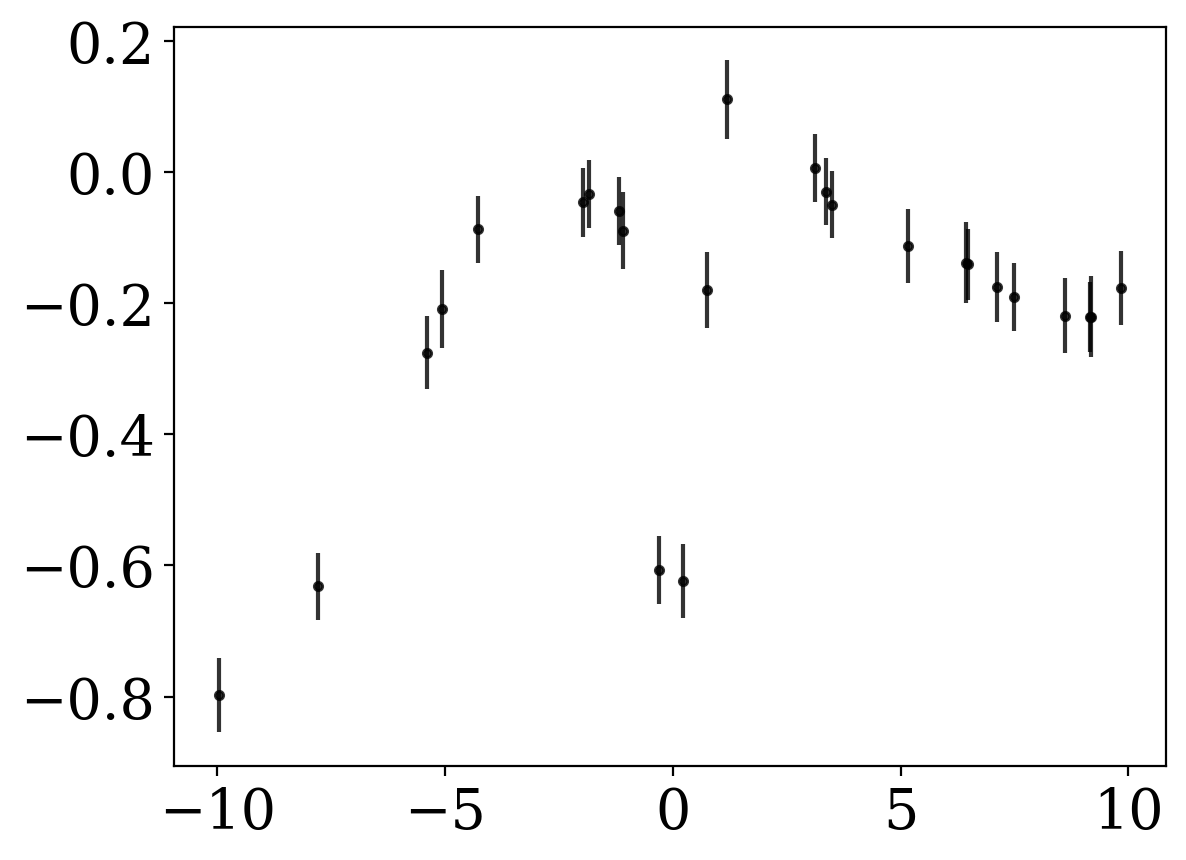

In [138]:
plt.errorbar(t, y, yerr,
             fmt='.', color='k', alpha=0.8)

In [139]:
class PolynomialModel(mgo): 
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")

    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b + 
               self.amp * np.exp(-0.5*(t-self.location)**2 * np.exp(-self.log_sigma2)))

In [141]:
model = george.GP(mean=PolynomialModel(m=0, 
                                      b=0, 
                                      amp=-1, 
                                      location=0.1, 
                                      log_sigma2=np.log(0.4)))
model.compute(t, yerr)

In [143]:
def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()

In [144]:
from corner import corner
import emcee

In [145]:
init = model.get_parameter_vector()
ndim, nwalkers = len(init), 32
p0 = init + 1e-8 * np.random.rand(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [146]:
p0, _ , _ = sampler.run_mcmc(p0, 200)
sampler.reset()

In [147]:
sampler.run_mcmc(p0, 500)

State([[ 1.33830717e-02 -1.98337271e-01 -5.03822287e-01 -4.84058253e-02
  -2.28010538e+00]
 [ 1.72217302e-02 -2.04662026e-01 -4.75942714e-01  2.65365865e-03
  -2.43873450e+00]
 [ 1.44442471e-02 -2.01128310e-01 -7.63743231e-01 -5.87555628e-02
  -3.05166194e+00]
 [ 1.32719065e-02 -1.83768748e-01 -2.26798552e+00 -5.36966067e-02
  -3.83846651e+00]
 [ 1.42773351e-02 -1.76405547e-01 -6.55035016e-01 -9.12216666e-02
  -2.47405956e+00]
 [ 1.33869573e-02 -1.86277677e-01 -1.40434965e+00 -4.97172345e-02
  -3.57447344e+00]
 [ 1.56039258e-02 -1.89295066e-01 -6.08449166e-01 -3.64781782e-02
  -2.74813279e+00]
 [ 1.49704945e-02 -2.13970410e-01 -4.88720883e-01 -6.74948880e-02
  -2.26057940e+00]
 [ 1.02407712e-02 -1.80641160e-01 -6.65288737e-01 -5.37375067e-02
  -2.80589943e+00]
 [ 1.26034188e-02 -1.86822972e-01 -6.44635554e-01 -3.44738467e-02
  -2.47566174e+00]
 [ 1.41533217e-02 -1.74049435e-01 -6.34548894e-01 -2.64838010e-02
  -2.39878919e+00]
 [ 1.49118543e-02 -2.05960648e-01 -9.33366259e-01 -6.904709

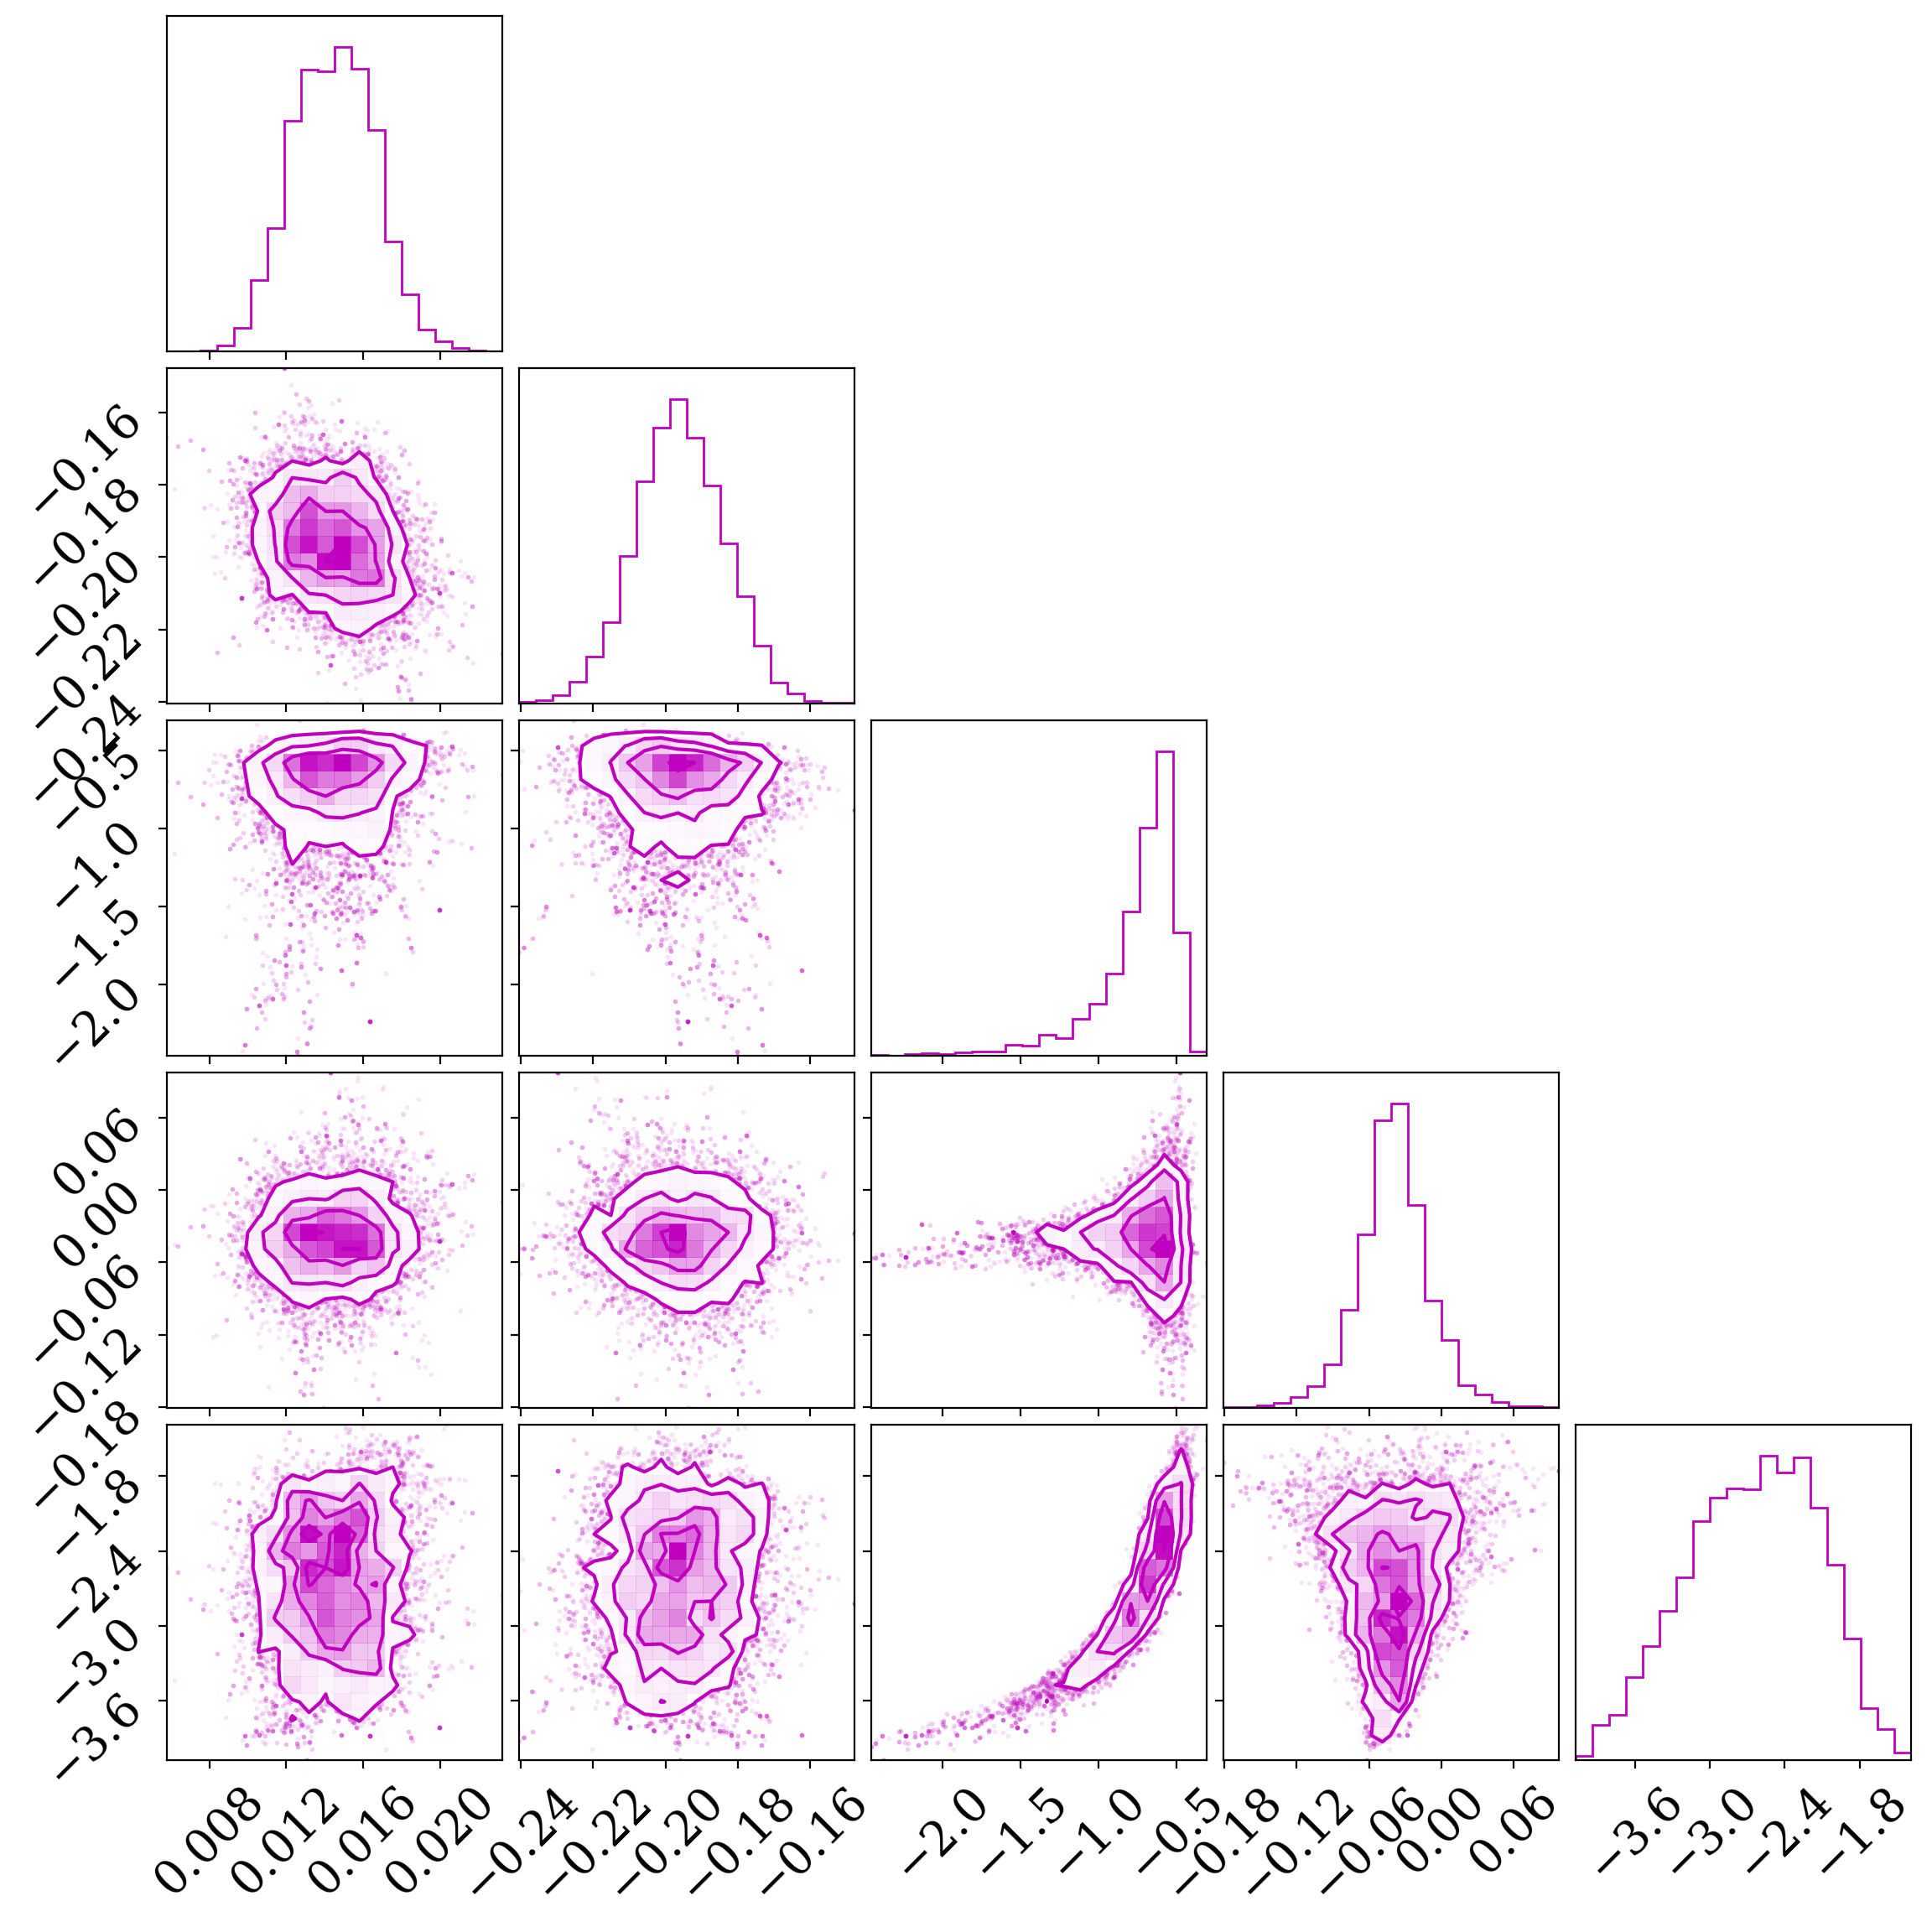

In [148]:
_ = corner(sampler.flatchain, color='m')

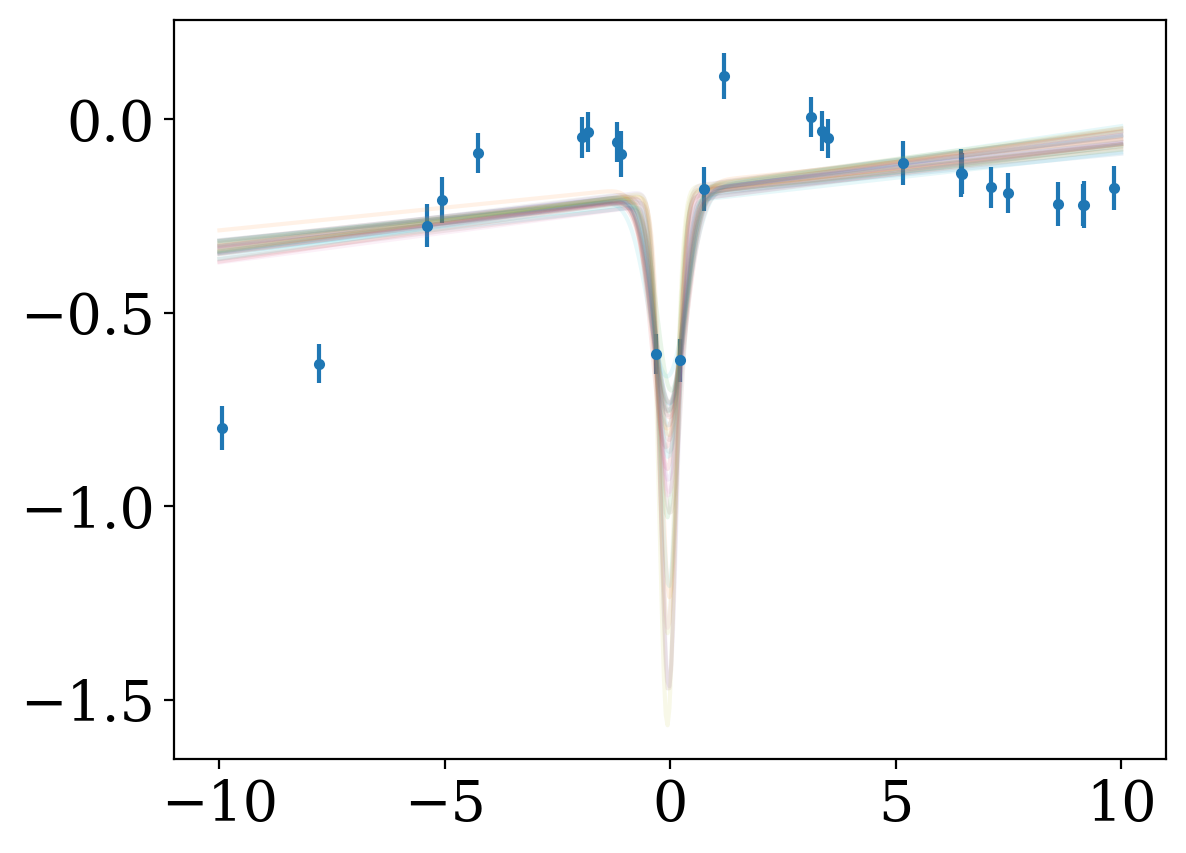

In [149]:
plt.errorbar(t, y, yerr, fmt='.')

x = np.linspace(-10, 10, 500)

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=30)]:
    model.set_parameter_vector(s)
    plt.plot(x, model.mean.get_value(x), alpha=0.1)

In [150]:
kwargs = dict(**true)
kwargs["bounds"] = dict(location=(-2, 2)) # adding boundaries to the location...

In [151]:
kwargs = dict(**true)
kwargs["bounds"] = dict(location=(-2, 2)) # adding boundaries to the location...
mean_model = Model(**kwargs)

In [152]:
gp = george.GP(np.var(y) * kernels.Matern32Kernel(10), mean=mean_model)

In [153]:
gp.compute(t, yerr)

In [154]:
def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior

In [157]:
init = model.get_parameter_vector()
ndim, nwalkers = len(init), 32
p0 = init + 1e-8 * np.random.rand(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [158]:
p0, lp , _ = sampler.run_mcmc(p0, 1_000)
sampler.reset()

In [159]:
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, lp , _ = sampler.run_mcmc(p0, 1_000)
sampler.reset()

In [160]:
sampler.run_mcmc(p0, 1_000)

State([[ 1.39061462e-02 -1.97848089e-01 -4.59089255e+00 -3.85907319e-02
  -4.25222718e+00]
 [ 1.33078063e-02 -2.02701675e-01 -2.12380204e+00 -3.94331186e-02
  -3.88658145e+00]
 [ 1.52542951e-02 -2.13255508e-01 -5.34035624e-01 -2.54628487e-02
  -2.17688547e+00]
 [ 1.66919262e-02 -1.89645841e-01 -1.61478008e+00 -5.47032855e-02
  -3.74500390e+00]
 [ 1.87989443e-02 -1.93799069e-01 -9.83349683e-01 -3.35599034e-02
  -3.19734119e+00]
 [ 1.41213210e-02 -1.99227646e-01 -8.64595490e-01 -3.74887218e-02
  -3.09579963e+00]
 [ 1.71509178e-02 -1.91090469e-01 -8.52352261e+00 -4.28516359e-02
  -4.49398709e+00]
 [ 1.29042997e-02 -1.95982926e-01 -6.81463295e+00 -4.41860269e-02
  -4.40694230e+00]
 [ 1.38518353e-02 -2.02036733e-01 -1.77233596e+00 -4.74439036e-02
  -3.71634301e+00]
 [ 1.35706046e-02 -1.91532196e-01 -1.15915337e+00 -3.57904368e-02
  -3.45656510e+00]
 [ 1.22624287e-02 -1.95344212e-01 -8.79613623e-01 -3.63412226e-02
  -3.17333141e+00]
 [ 1.16413643e-02 -1.96227532e-01 -5.30901120e-01  6.545622

In [162]:
gp.predict(y, x_pred, return_var=True)

In [170]:
gp.log_likelihood(y, quiet=True)

22.848414943179634

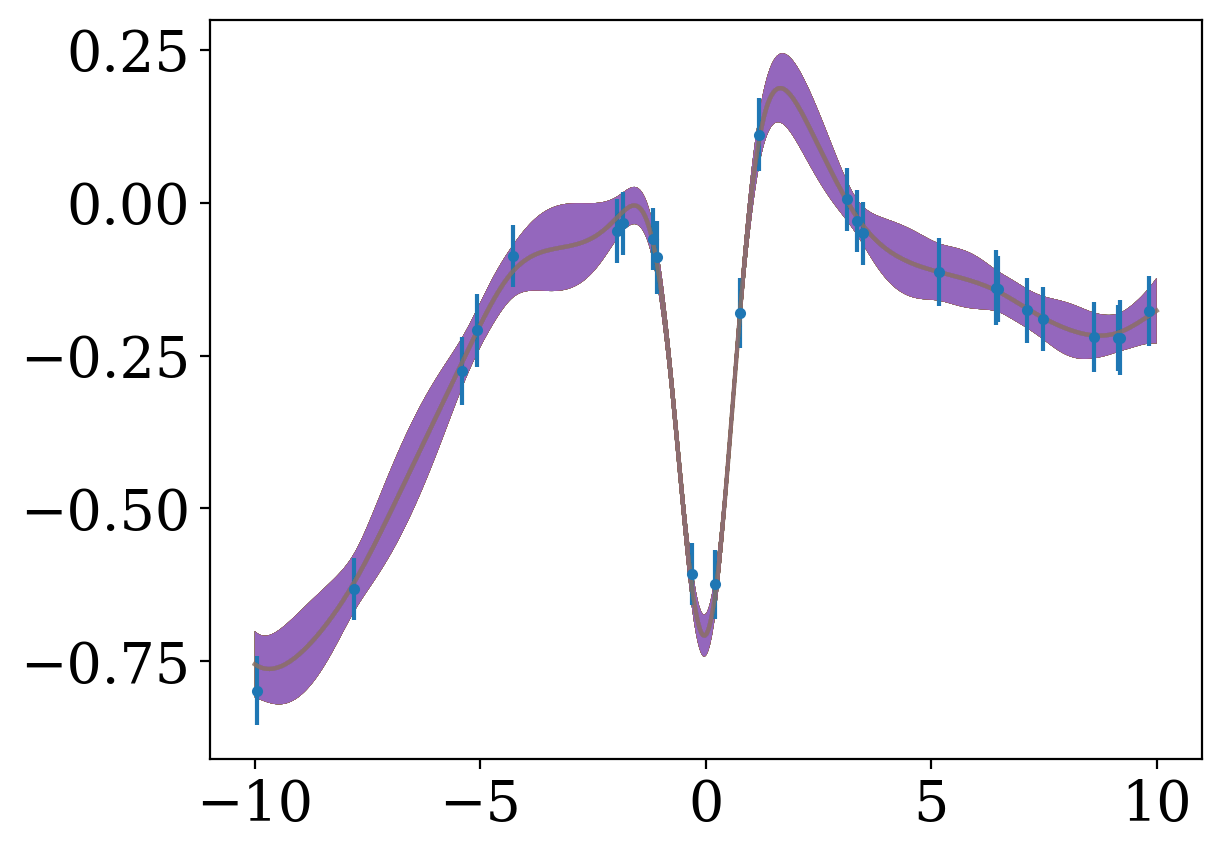

In [167]:
plt.errorbar(t, y, yerr, fmt='.')

x = np.linspace(-10, 10, 500)

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=15)]:
    model.set_parameter_vector(s)
    mu = gp.predict(y, x, return_var=True)
    plt.plot(x, mu[0], alpha=0.1)
    plt.fill_between(x, mu[0]-np.sqrt(mu[1]), mu[0]+np.sqrt(mu[1]))

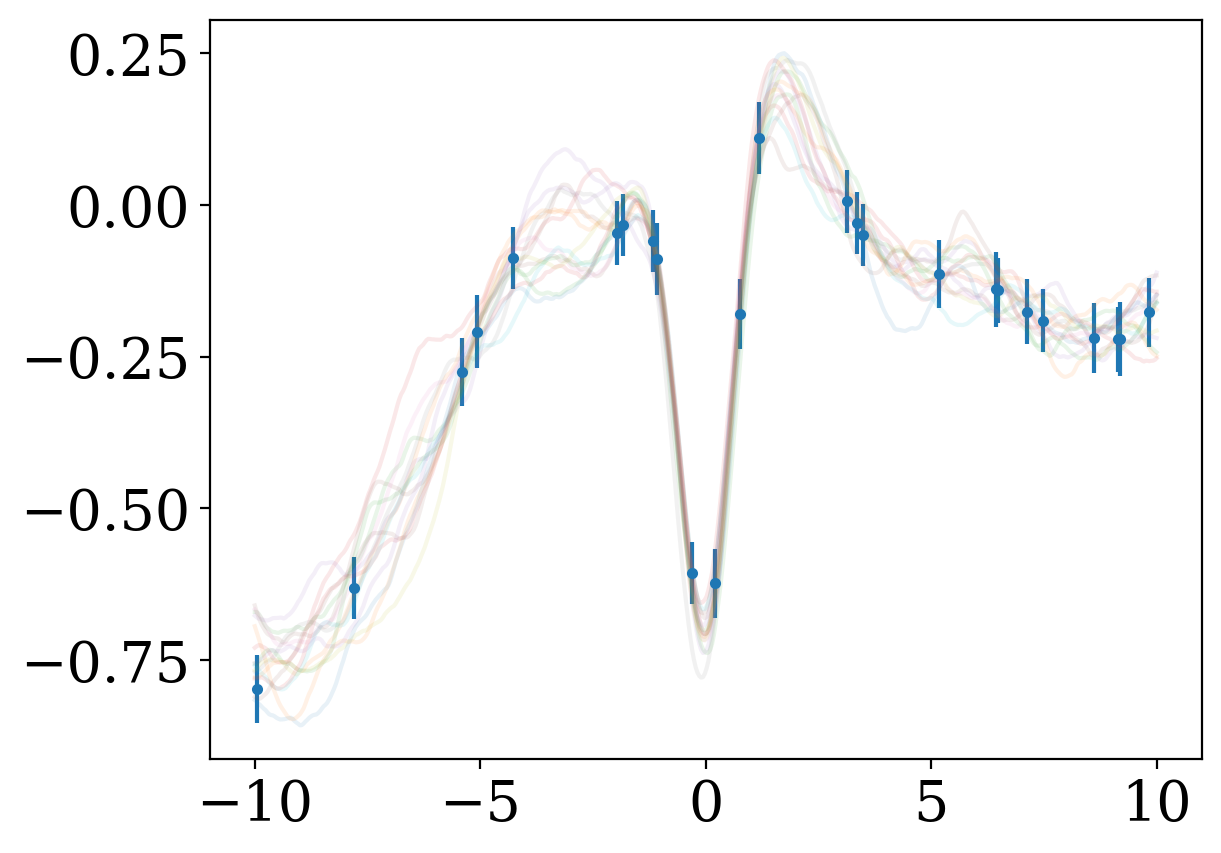

In [161]:
plt.errorbar(t, y, yerr, fmt='.')

x = np.linspace(-10, 10, 500)

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=15)]:
    model.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    plt.plot(x, mu, alpha=0.1)

In [523]:
bestm = []
for i in range(5):
     bestm.append(np.median(sampler.flatchain[:,i]))

In [524]:
bestm

[0.007810268328985178,
 0.09830064932714126,
 -2.5559882670713394,
 1.009845231997007,
 0.22492675386377084]

In [525]:
model.set_parameter_vector(bestm)

In [526]:
model.set_parameter_vector(bestm)
model_best = gp.sample_conditional(y, x)

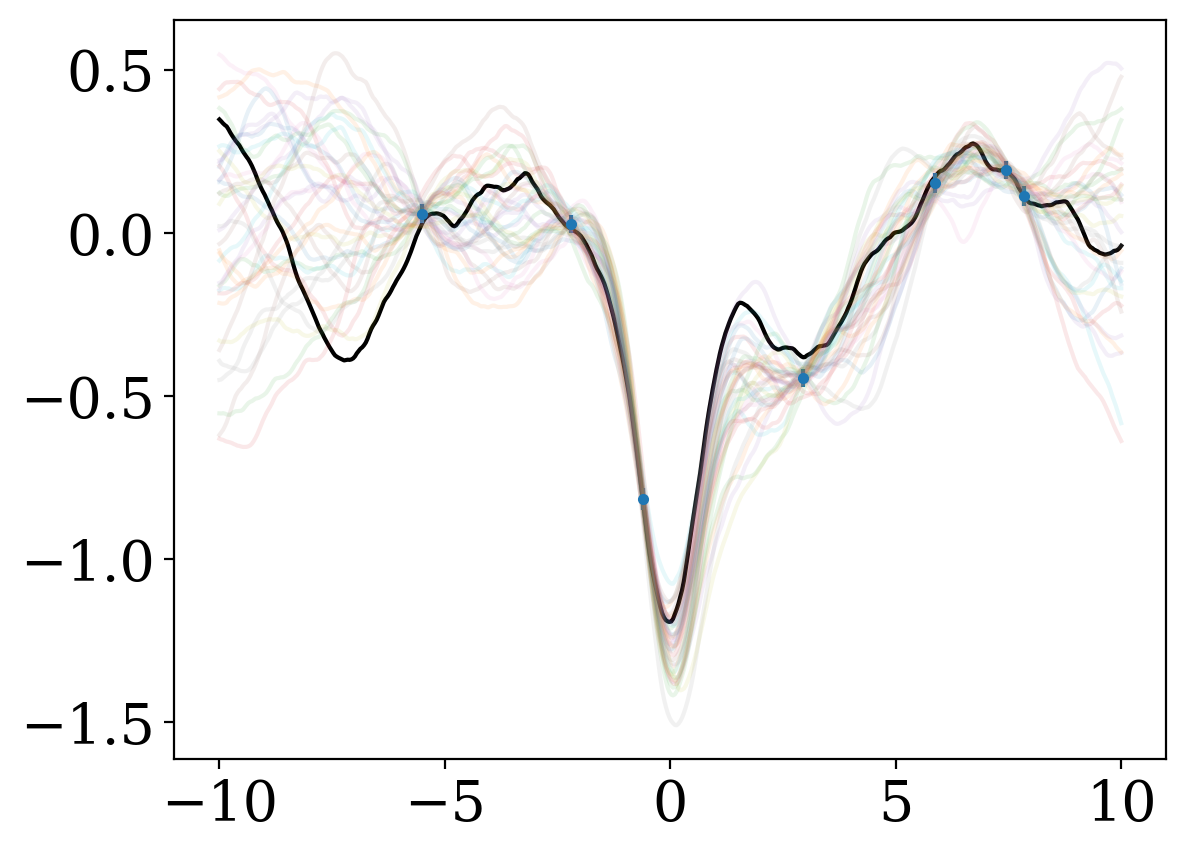

In [527]:
plt.plot(x, model_best, color='k')

plt.errorbar(t, y, yerr, fmt='.')

x = np.linspace(-10, 10, 500)

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=35)]:
    model.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    plt.plot(x, mu, alpha=0.1)

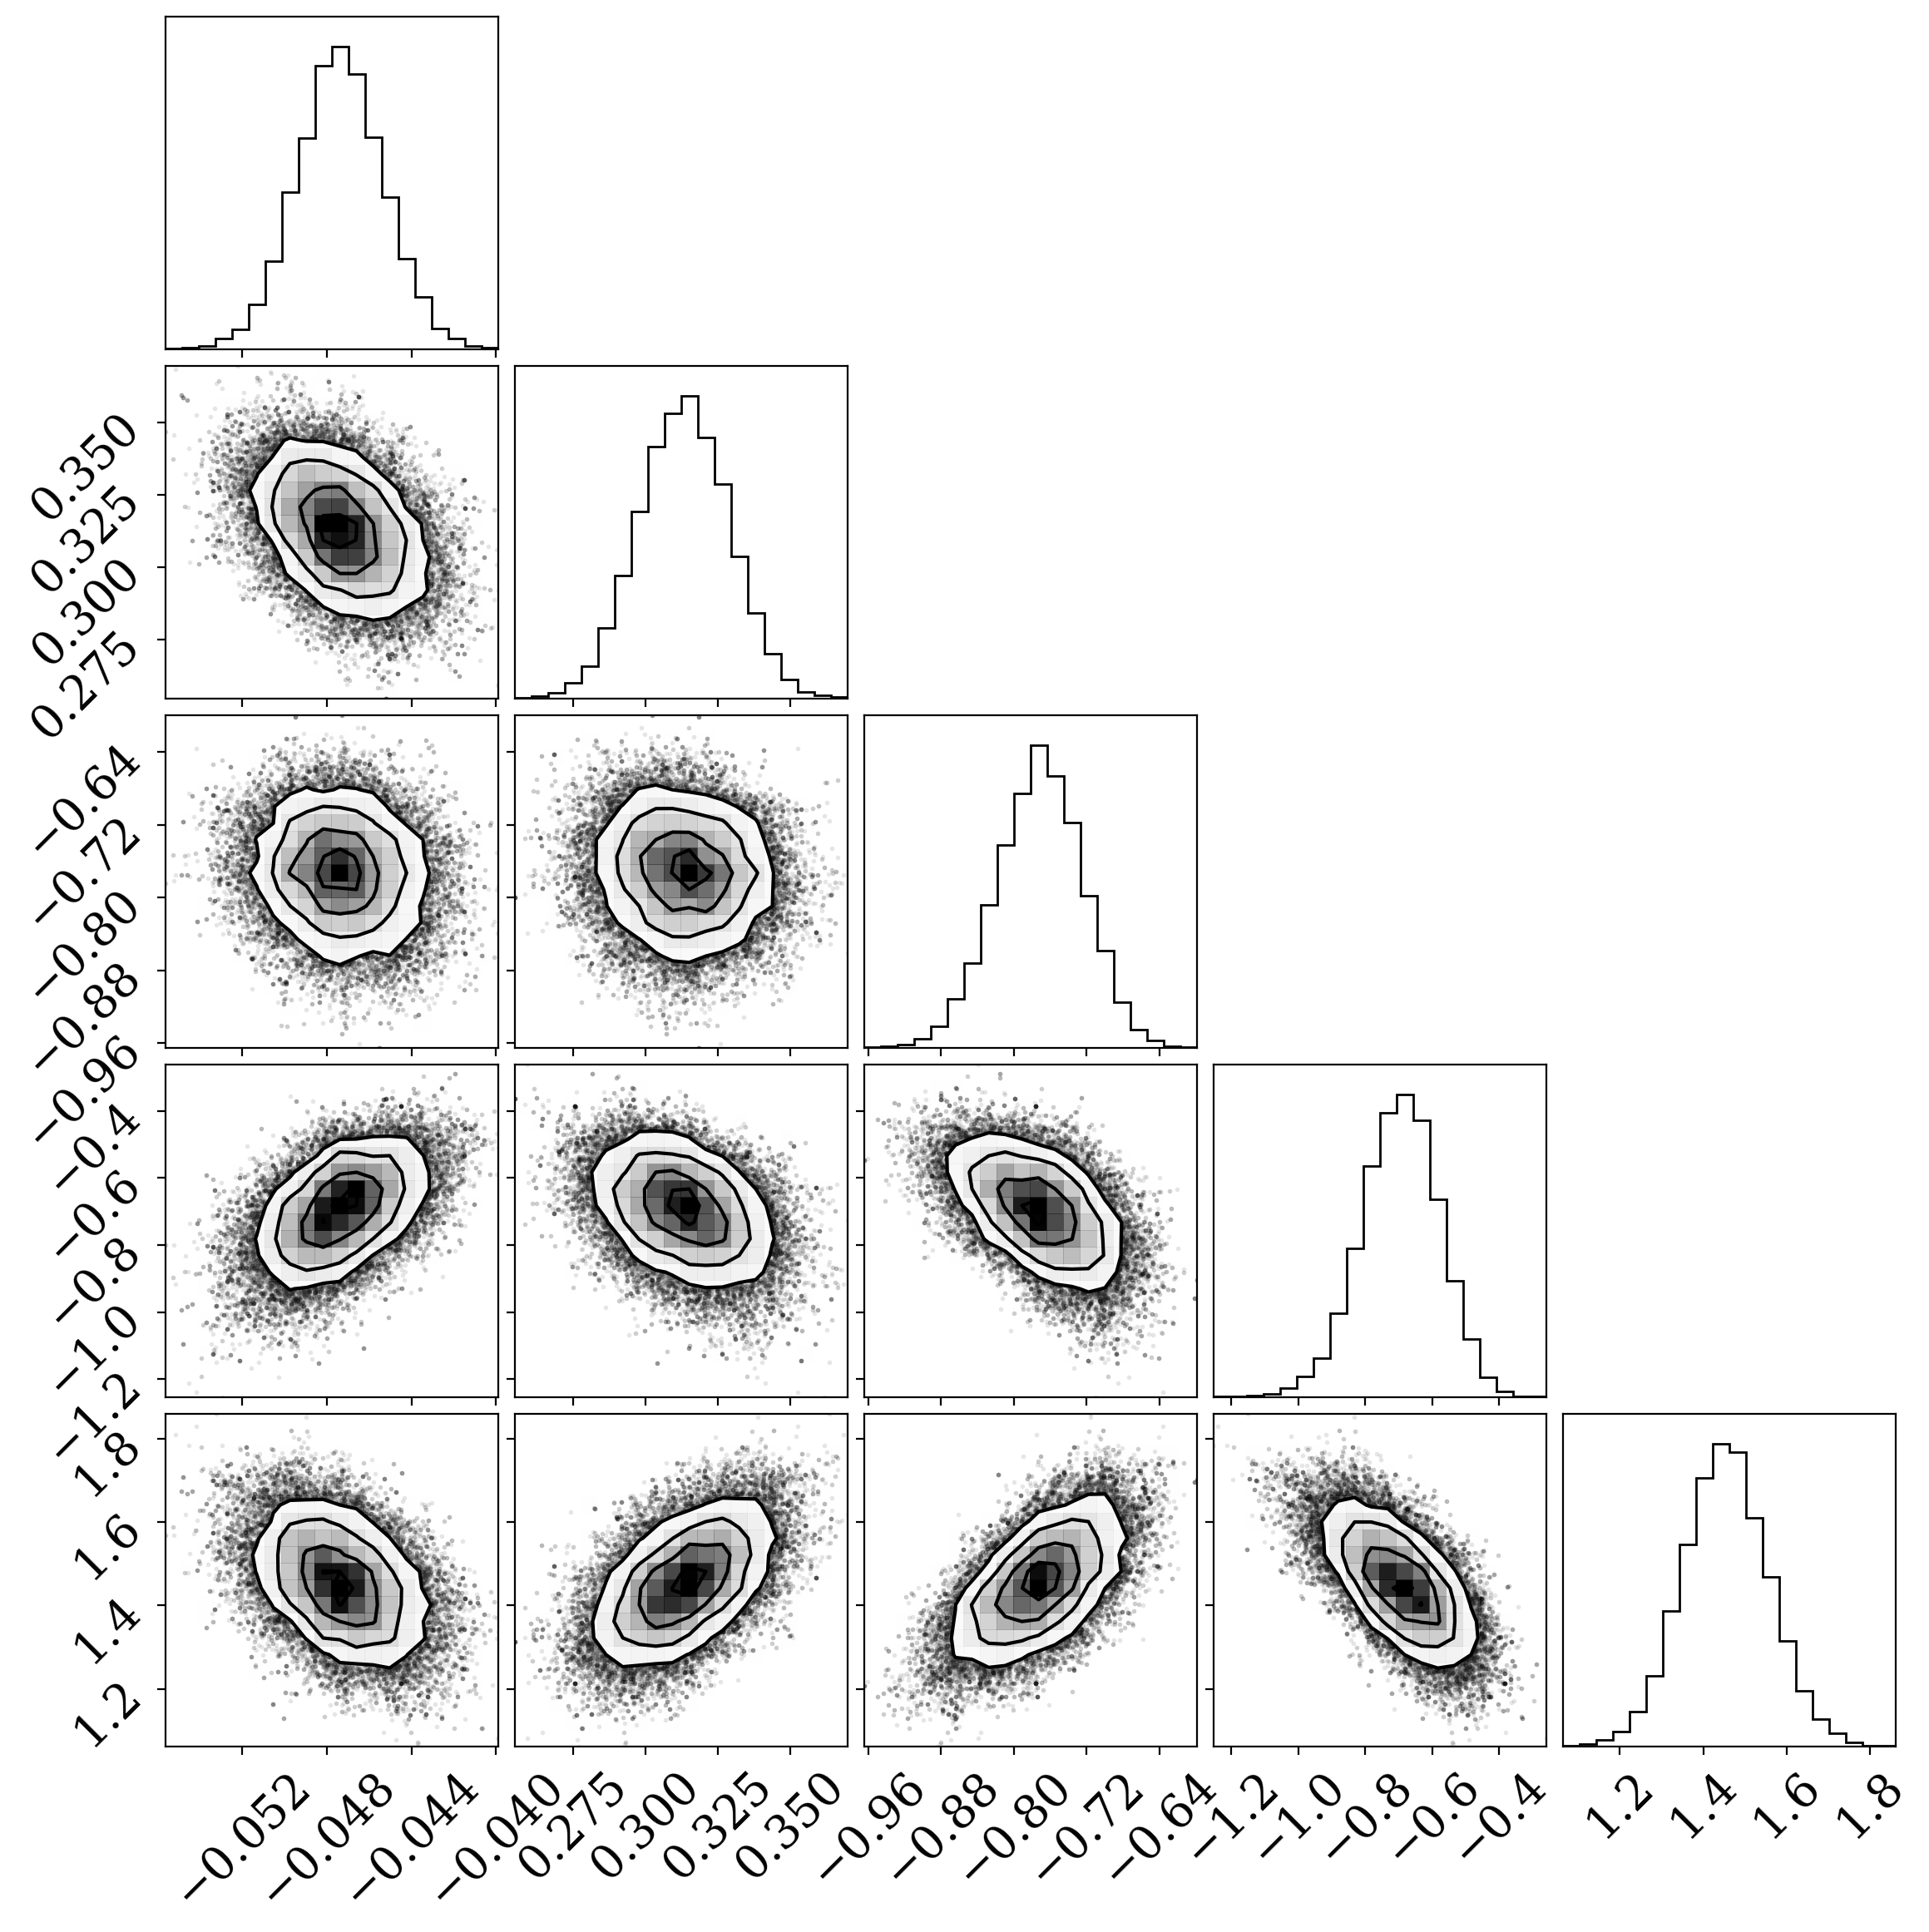

In [339]:
_ = corner(sampler.flatchain)

In [288]:
parameter_names = ("m", "b", "amp", "location", "log_sigma2")

for i in range(5):
    print (parameter_names[i],':', np.median(sampler.flatchain[:,i]))

m : -0.03677012424614955
b : 0.4603165936444026
amp : -1.345390626834101
location : 0.3402989487926956
log_sigma2 : -0.7849161144752511


In [297]:
names = gp.get_parameter_names()
tri_cols = ["amp", "location", "log_sigma2"]
tri_labels = ["a", "$\ell$", "$\sigma$"]
inds = np.array([names.index("mean:"+k) for k in tri_cols])

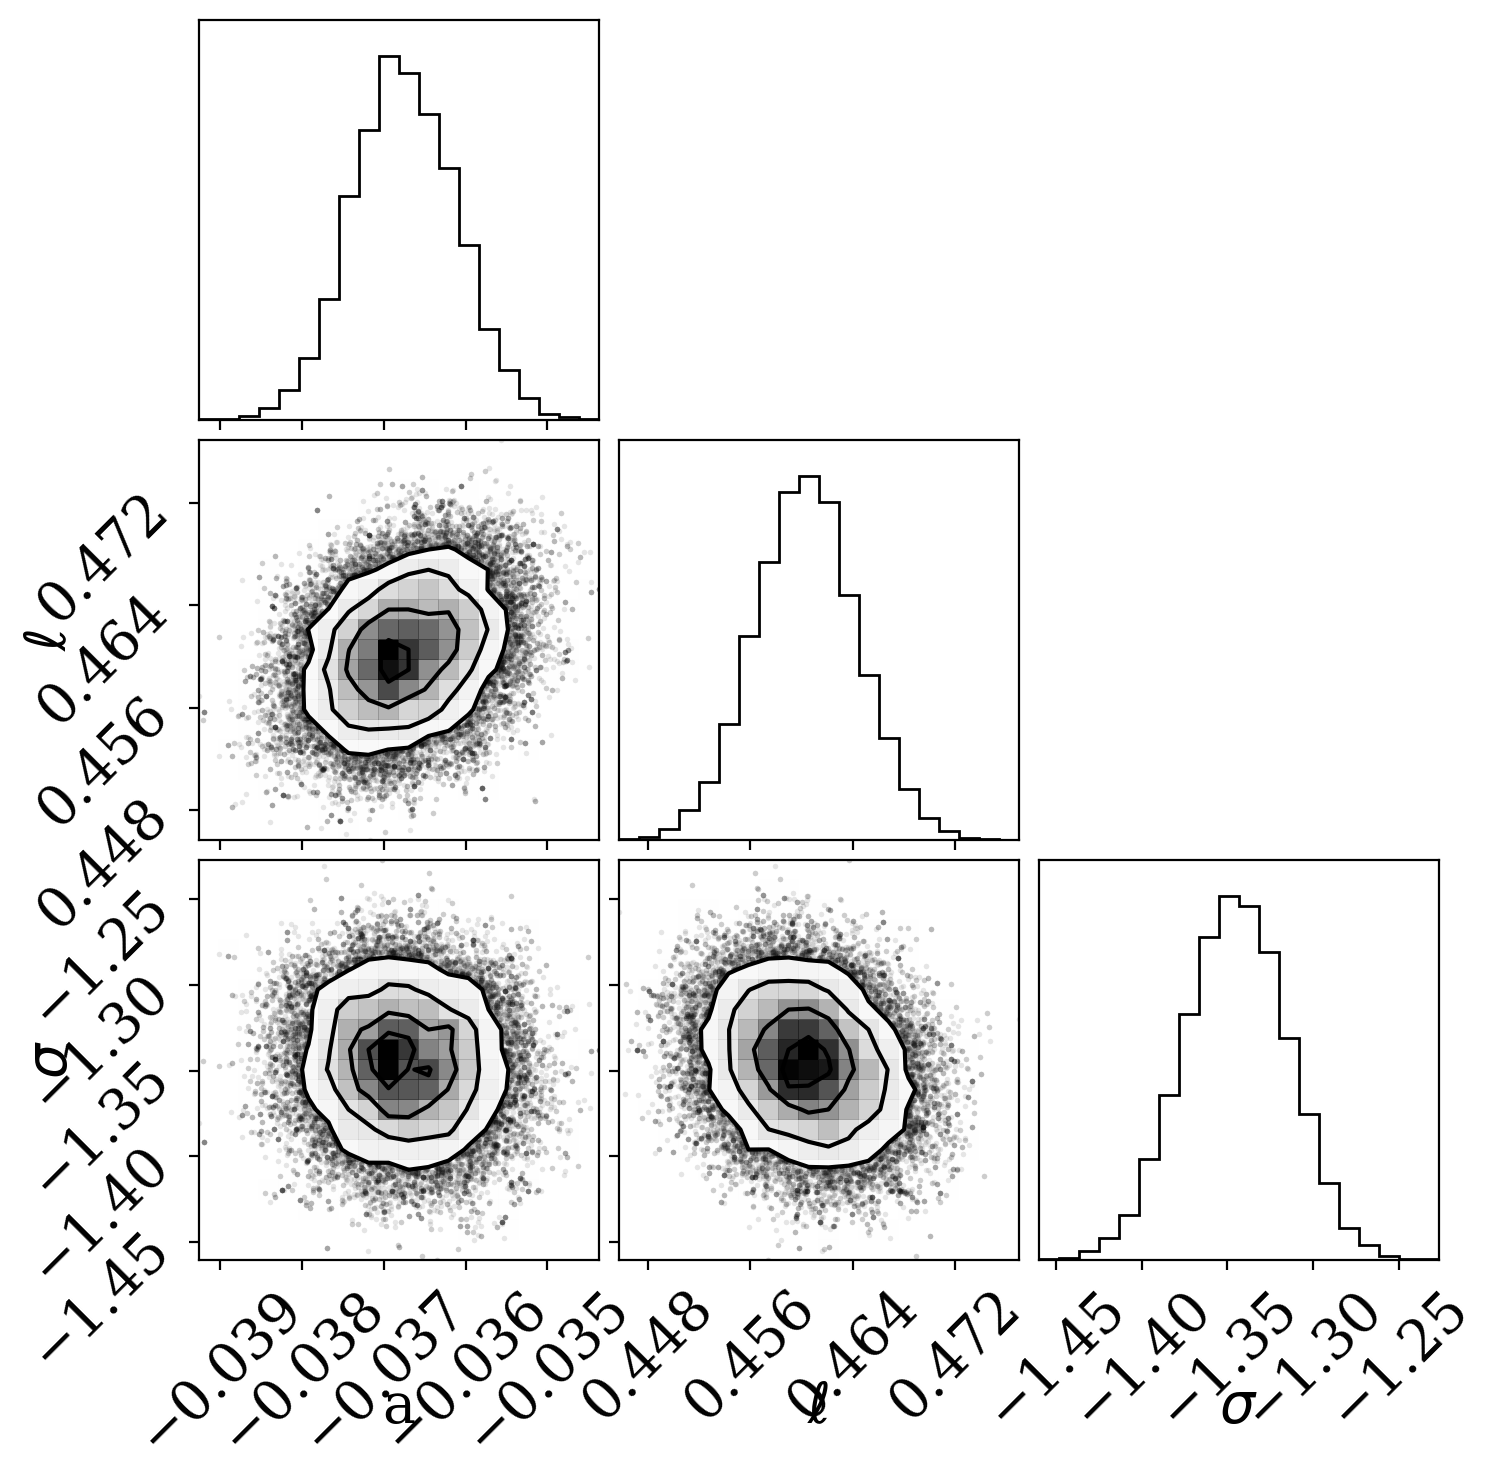

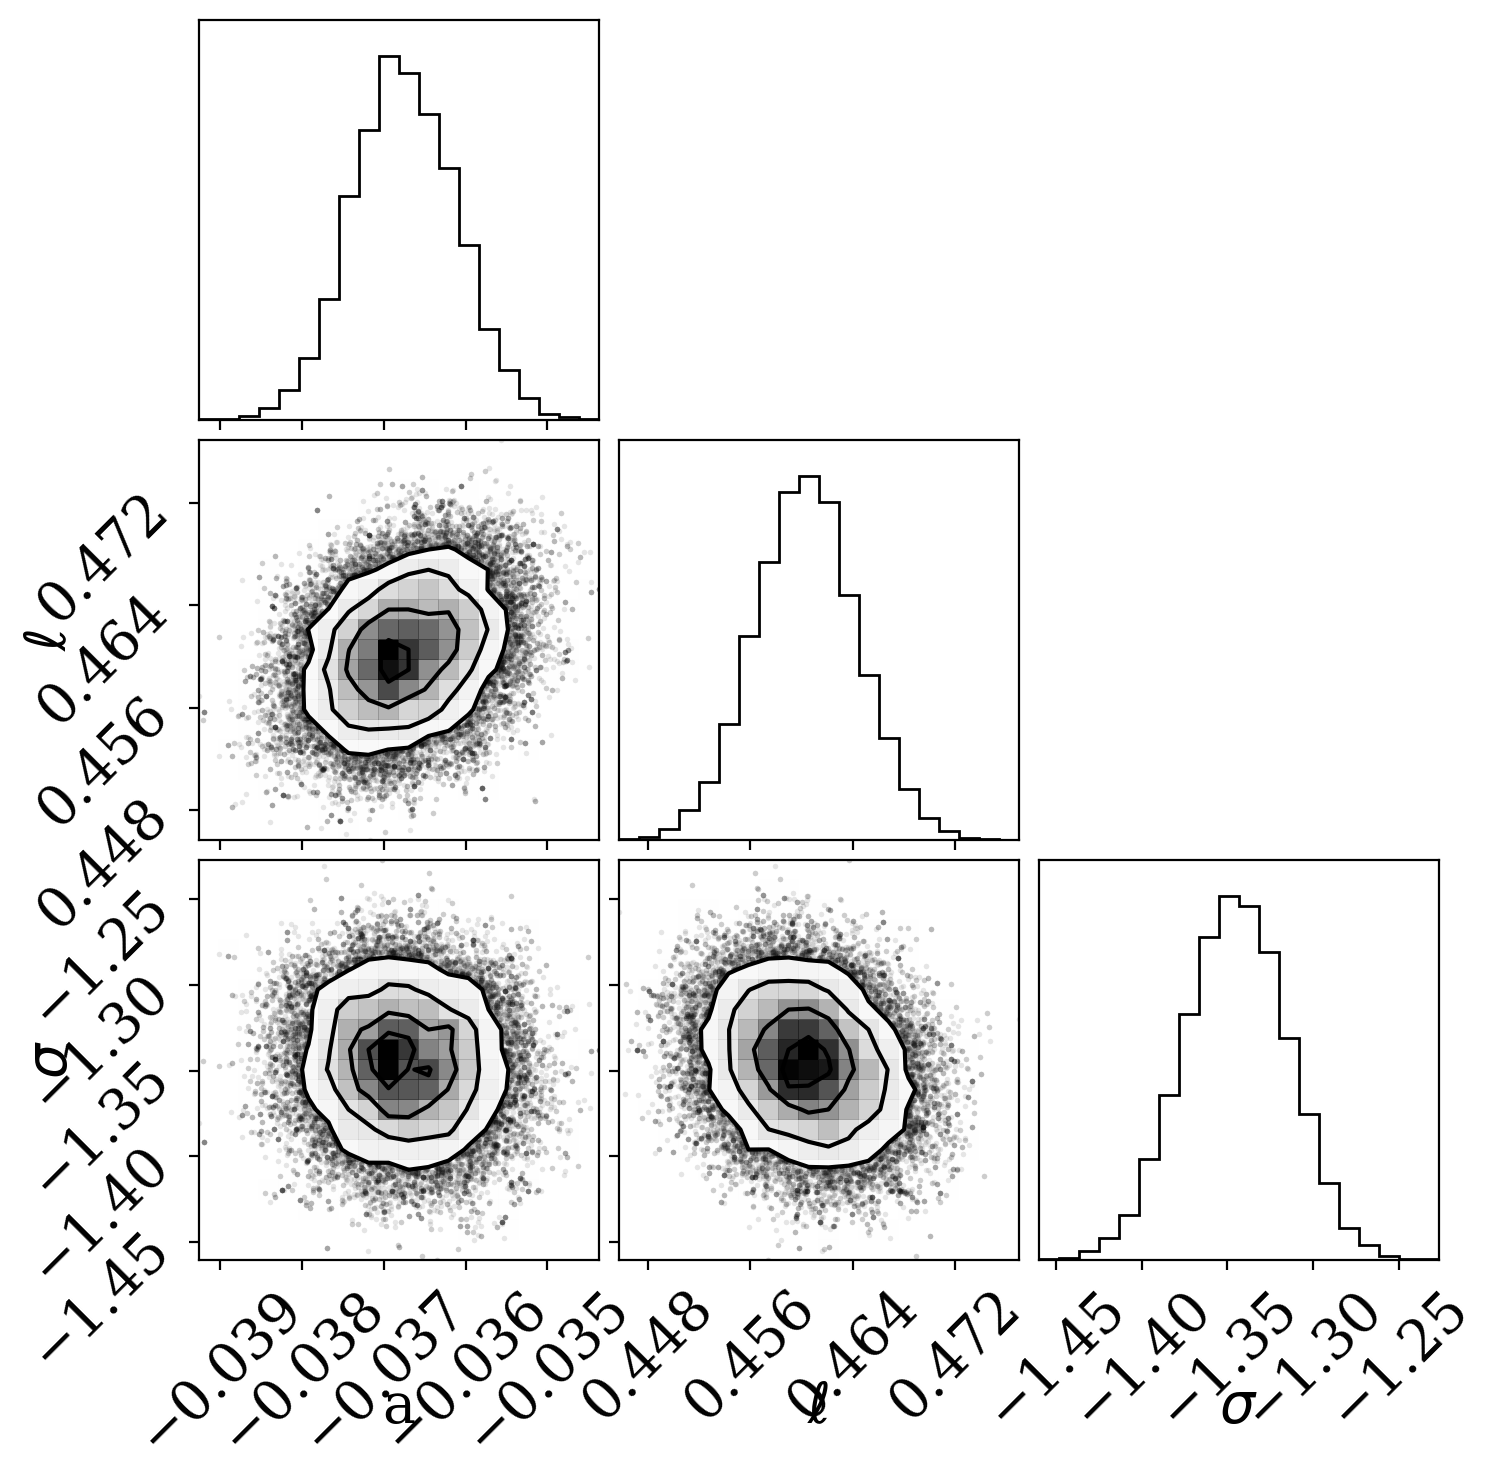

In [299]:
corner(sampler.flatchain[:, inds], labels=tri_labels)

## Implementation 

First use the polynomial Gaussian
```python

from george.modeling import Model as mgo

class Model(mgo):
    parameter_names = ("amp", "location", "log_sigma2")
    
    def get_value(self, t): 
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))



class PolynomialModel(mgo): 
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")

    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b + 
               self.amp * np.exp(-0.5*(t-self.location)**2 * np.exp(-self.log_sigma2)))
    
    
def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()



def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior



```

In [115]:
def model_gp_dip(X, Y, YERR, i0):
    """i0: dictionary with the true names..."""
    
    kwargs = dict(**i0)
    kwargs["bounds"] = dict(m=(-np.inf, np.inf), 
                                b=(-np.inf, np.inf), 
                                amp=(-np.inf, np.inf), 
                                location=(-2,2),
                                log_sigma2=(-np.inf, np.inf)) # adding boundaries to the location...
    
    mean_model = Model(**kwargs)
                           
    #TODO: what kernel and what scale length to choose?                        
    gp = george.GP(np.var(Y) * kernels.Matern32Kernel(5), mean=mean_model)
    
    gp.compute(X, YERR) 
        
    def lnprob2_new(p):
        gp.set_parameter_vector(p)
        return gp.log_likelihood(Y, quiet=True) + gp.log_prior()
    
    init = gp.get_parameter_vector()
    ndim, nwalkers = len(init), 32
    
    p0 = init + 1e-8 * np.random.rand(nwalkers, ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2_new)
    
    ## MCMC might need adjusting on nsamplers
    p0, lp , _ = sampler.run_mcmc(p0, 200)
    sampler.reset()

    p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
    sampler.reset()
    
    #p0, lp , _ = sampler.run_mcmc(p0, 1_000)
    #sampler.reset()

    sampler.run_mcmc(p0, 1_000)
    
    samples = sampler.flatchain # fetch the flatchain samples
    
    ## What to return? ##
    arg_mu = []
    for i in range(5):
         arg_mu.append(np.median(samples[:,i]))
            
    x = np.linspace(min(X), max(X), 1_000)
    
    gp.set_parameter_vector(arg_mu)
    model_best = gp.sample_conditional(Y, x)
    
    return x, model_best


In [116]:
start = dict(amp=-1, location=0, log_sigma2=np.log(0.4))

In [117]:
%%time
res = model_gp_dip(t, y, yerr, start)

CPU times: user 9.06 s, sys: 3.31 s, total: 12.4 s
Wall time: 7.48 s


Text(0.5, 0, 'Time')

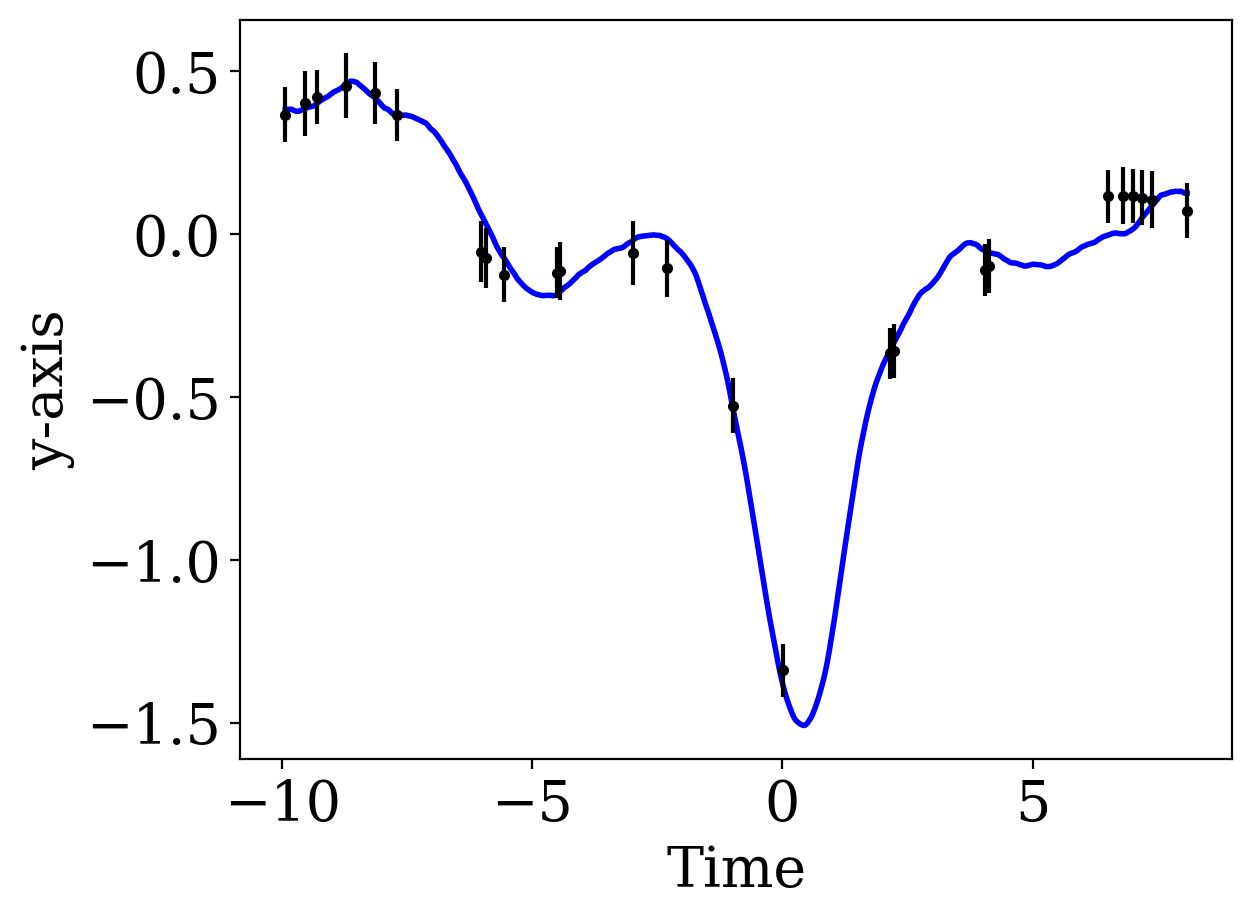

In [119]:
plt.plot(res[0], res[1], color='blue', lw=2)
plt.errorbar(t, y, yerr, fmt='.', color='k')
plt.ylabel("y-axis")
plt.xlabel("Time")